In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys  
import pandas as pd
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.ar_model import ARResults
from scipy.interpolate import Rbf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/world-bank-country-demographics/df_demographics.pkl
/kaggle/input/world-bank-country-demographics/World_Bank_Pop_Density.csv
/kaggle/input/world-bank-country-demographics/World_Bank_Age_65plus_by_Country.csv
/kaggle/input/world-bank-country-demographics/World_Bank_Pop_by_Country.csv
/kaggle/input/covid19-global-forecasting-week-1/train.csv
/kaggle/input/covid19-global-forecasting-week-1/submission.csv
/kaggle/input/covid19-global-forecasting-week-1/test.csv


In [2]:
train_data = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-1/train.csv')
population = pd.read_csv('/kaggle/input/world-bank-country-demographics/World_Bank_Pop_by_Country.csv')
p_density = pd.read_csv('/kaggle/input/world-bank-country-demographics/World_Bank_Pop_Density.csv')
population_density = pd.merge(population[['Country Code','Country Name','2018']], p_density[['Country Code','2018']], on = 'Country Code')
population_density.columns = ['Country Code', 'Country Name', 'Population', 'Density']
population_density= population_density.set_value(249,'Country Name', 'US')
population_density= population_density.set_value(29,'Country Name', 'Brunei')
population_density= population_density.set_value(42,'Country Name', 'Congo (Brazzaville)')
population_density= population_density.set_value(41,'Country Name', 'Congo (Kinshasa)')
population_density= population_density.set_value(52,'Country Name', 'Czechia')
population_density= population_density.set_value(65,'Country Name', 'Egypt')
population_density= population_density.set_value(92,'Country Name', 'French Guiana')
population_density= population_density.set_value(124,'Country Name', 'Korea, South')
population_density= population_density.set_value(252,'Country Name', 'Venezuela')
population_density= population_density.set_value(84,'Country Name', 'The Gambia')
population_density= population_density.set_value(21,'Country Name', 'The Bahamas')
population_density= population_density.set_value(219,'Country Name', 'Slovakia')
population_density= population_density.set_value(251,'Country Name', 'Saint Vincent and the Grenadines')
population_density= population_density.set_value(131,'Country Name', 'Saint Lucia')
population_density= population_density.set_value(200,'Country Name', 'Russia')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Re

In [3]:
train_data.nunique()

Id                17892
Province/State      128
Country/Region      163
Lat                 272
Long                276
Date                 63
ConfirmedCases     1023
Fatalities          204
dtype: int64

In [4]:
population_density.shape

(264, 4)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f8c8ee00208>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8c8efe4a58>)

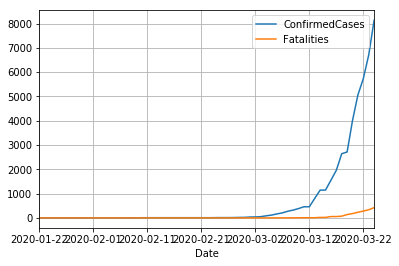

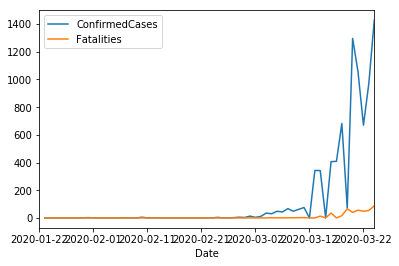

In [5]:
Country = 'United Kingdom'
df_c = train_data[train_data['Country/Region'] == Country][['Date','Province/State','ConfirmedCases','Fatalities']]
df_c.set_index('Date', inplace=True)
df_acumed_daycases = pd.DataFrame(df_c.groupby('Date')['ConfirmedCases','Fatalities'].sum())
df_diff_daycases = pd.DataFrame(df_c.groupby(['Date'])['ConfirmedCases','Fatalities'].sum().diff())
df_acumed_daycases.plot(grid=True),df_diff_daycases.plot()

In [6]:
def predict_n_steps_AR(data, n_steps, use_new_model = True,maxlag=3):
    data_history = data
    if n_steps < 5:
        for i in range(n_steps):
            model = AR(data_history)
            model_fit = model.fit(maxlag=maxlag, disp=True)
            yhat = model_fit.predict(len(data_history), len(data_history))
            data_history = np.concatenate((data_history, yhat))
    else:
        total = sum(data_history)
        if total < 1000:
            for i in range(min(14,n_steps)):
                model = AR(data_history)
                model_fit = model.fit(maxlag=1, disp=True)
                yhat = model_fit.predict(len(data_history), len(data_history))
                data_history = np.concatenate((data_history, yhat))
            if sum(data_history) >= 15000:
                for i in range(14,min(20,n_steps)):
                    model = AR(data_history)
                    model_fit = model.fit(maxlag=3, disp=True)
                    yhat = model_fit.predict(len(data_history), len(data_history))
                    data_history = np.concatenate((data_history, yhat))
                for i in range(20,n_steps):
                    t,d,s,p,b,r = ['add', True, None, None, False, True]
                    model = ExponentialSmoothing(data_history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
                    model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
                    yhat = model_fit.predict(len(data_history), len(data_history))
                    data_history = np.concatenate((data_history, yhat))
            else:
                for i in range(14,n_steps):
                    model = AR(data_history)
                    model_fit = model.fit(maxlag=1, disp=True)
                    yhat = model_fit.predict(len(data_history), len(data_history))
                    data_history = np.concatenate((data_history, yhat))
        else:
            for i in range(n_steps):
                model = AR(data_history)
                model_fit = model.fit(maxlag=maxlag, disp=True)
                yhat = model_fit.predict(len(data_history), len(data_history))
                data_history = np.concatenate((data_history, yhat))
    return data_history

In [7]:
_list=[]
for country in train_data['Country/Region'].unique():
    df_c = train_data[train_data['Country/Region'] == country][['Country/Region','Province/State','Date','ConfirmedCases','Fatalities']]
    if df_c['Province/State'].nunique()==0:
        _list.append([df_c[df_c['ConfirmedCases'].diff()<0].index,'ConfirmedCases', df_c.loc[df_c[df_c['ConfirmedCases'].diff()<0].index-1, 'ConfirmedCases'].values])
        train_data.set_value(df_c[df_c['ConfirmedCases'].diff()<0].index,'ConfirmedCases', df_c.loc[df_c[df_c['ConfirmedCases'].diff()<0].index-1, 'ConfirmedCases'].values)
    else:
        for province in df_c['Province/State'].unique():
            df_d = df_c[df_c['Province/State'] == province][['Country/Region','Province/State','ConfirmedCases','Fatalities']]
            _list.append([df_d[df_d['ConfirmedCases'].diff()<0].index,'ConfirmedCases', df_d.loc[df_d[df_d['ConfirmedCases'].diff()<0].index-1, 'ConfirmedCases'].values])
            train_data.set_value(df_d[df_d['ConfirmedCases'].diff()<0].index,'ConfirmedCases', df_d.loc[df_d[df_d['ConfirmedCases'].diff()<0].index-1, 'ConfirmedCases'].values)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # This is added back by InteractiveShellApp.init_path()


In [8]:
train_data.shape

(17892, 8)

In [9]:
import numpy as ro
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)
arr_cc = np.empty(0, int)
arr_fa = np.empty(0, int)
arr_fa_rate = np.empty(0, int)
_list = []
X = 30
Y = 50
for country in train_data['Country/Region'].unique():
    df_c = train_data[train_data['Country/Region'] == country][['Country/Region','Province/State','Date','ConfirmedCases','Fatalities']]
    df_c.set_index('Date', inplace=True)    
    if df_c['Province/State'].nunique()==0:
        
        df_acumed_daycases = pd.DataFrame(df_c.groupby('Date')['ConfirmedCases','Fatalities'].sum())
        df_diff_daycases = pd.DataFrame(df_c.groupby(['Date'])['ConfirmedCases','Fatalities'].sum().diff())
        data_cc = df_acumed_daycases['ConfirmedCases'].astype('float')
        result_cc = np.absolute(predict_n_steps_AR(data_cc, X, use_new_model = True))
        
        try:
            population_ds = population_density[population_density['Country Name']==country][['Population', 'Density']]
            max_cc = population_ds['Population']*0.7
            indices = np.nonzero(result_cc > max_cc.values[0])
            replacement = max_cc
            for index in indices:
                result_cc[index] = replacement
        except:
            result_cc = np.absolute(predict_n_steps_AR(data_cc, X, use_new_model = True))
        
        arr_cc = np.append(arr_cc, result_cc[Y:])
        data_fa = df_acumed_daycases['Fatalities'].astype('float')
        
        
        result_fa = np.absolute(predict_n_steps_AR(data_fa, X, use_new_model = True))
        
        indices_cc = np.nonzero(result_cc > 200)
        if sum(result_fa) == 0 and len(indices_cc) > 0:
            replacement = result_cc*0.05
            for index in indices_cc:
                result_fa[index] = replacement[index]

        rate = np.divide(result_fa,result_cc)
        indices = np.nonzero(rate > 0.09)
        replacement = result_cc*0.09
        for index in indices:
            result_fa[index] = replacement[index]

        arr_fa = np.append(arr_fa, result_fa[Y:])

        arr_fa_rate = np.append(arr_fa_rate, np.divide(result_fa[Y:],result_cc[Y:]))

    else:
        df_acumed_daycases = pd.DataFrame(df_c.groupby('Date')['ConfirmedCases','Fatalities'].sum())
        df_diff_daycases = pd.DataFrame(df_c.groupby(['Date'])['ConfirmedCases','Fatalities'].sum().diff())
        data_cc = df_acumed_daycases['ConfirmedCases'].astype('float')
        result_cc = np.absolute(predict_n_steps_AR(data_cc, X, use_new_model = True))
        population_ds = population_density[population_density['Country Name']==country][['Population', 'Density']]
        max_cc = population_ds['Population']*0.7
        
        try:            
            indices = np.nonzero(result_cc > max_cc.values[0])
            _list.append([country,max_cc,result_cc, np.nonzero(result_cc > max_cc.values[0])])
            for province in df_c['Province/State'].unique():
                df_d = df_c[df_c['Province/State'] == province][['Country/Region','Province/State','ConfirmedCases','Fatalities']]            
                df_acumed_daycases = pd.DataFrame(df_d.groupby('Date')['ConfirmedCases','Fatalities'].sum())
                df_diff_daycases = pd.DataFrame(df_d.groupby(['Date'])['ConfirmedCases','Fatalities'].sum().diff())
                data_cc = df_acumed_daycases['ConfirmedCases'].astype('float')
                result_cc = np.absolute(predict_n_steps_AR(data_cc, X, use_new_model = True))            

                max_cc = result_cc[indices.values[0]-1]
                
                for index in indices:
                    result_cc[index] = max_cc

                arr_cc = np.append(arr_cc, result_cc[Y:])
                
                data_fa = df_acumed_daycases['Fatalities'].astype('float')
                result_fa = np.absolute(predict_n_steps_AR(data_fa, X, use_new_model = True))

                indices_cc = np.nonzero(result_cc > 200)
                if sum(result_fa) == 0 and len(indices_cc) > 0:
                    replacement = result_cc*0.05
                    for index in indices_cc:
                        result_fa[index] = replacement[index]


                rate = np.divide(result_fa,result_cc)
                indices = np.nonzero(rate > 0.09)
                replacement = result_cc*0.09
                for index in indices:
                    result_fa[index] = replacement[index]

                arr_fa = np.append(arr_fa, result_fa[Y:])
                arr_fa_rate = np.append(arr_fa_rate, np.divide(result_fa[Y:],result_cc[Y:]))
        except:
            arr_list = []
            for province in df_c['Province/State'].unique():
                df_d = df_c[df_c['Province/State'] == province][['Country/Region','Province/State','ConfirmedCases','Fatalities']] 
                df_acumed_daycases = pd.DataFrame(df_d.groupby('Date')['ConfirmedCases','Fatalities'].sum())
                df_diff_daycases = pd.DataFrame(df_d.groupby(['Date'])['ConfirmedCases','Fatalities'].sum().diff())
                data_cc = df_acumed_daycases['ConfirmedCases'].astype('float')
                result_cc = predict_n_steps_AR(data_cc.astype(int), 36, use_new_model = True)
                arr_list.append(result_cc)
            try:
                indices_whole = np.nonzero([sum(x) for x in zip(*arr_list)] > max_cc.values[0])
            except:pass
            for province in df_c['Province/State'].unique():
                df_d = df_c[df_c['Province/State'] == province][['Country/Region','Province/State','ConfirmedCases','Fatalities']]            
                df_acumed_daycases = pd.DataFrame(df_d.groupby('Date')['ConfirmedCases','Fatalities'].sum())
                df_diff_daycases = pd.DataFrame(df_d.groupby(['Date'])['ConfirmedCases','Fatalities'].sum().diff())
                data_cc = df_acumed_daycases['ConfirmedCases'].astype('float')
                result_cc = np.absolute(predict_n_steps_AR(data_cc, X, use_new_model = True))            

                try:
                    replacement = result_cc[indices_whole[0][0]-1]
                    for index in indices_whole[0]:
                        result_cc[index] = replacement
                except:
                    pass

                arr_cc = np.append(arr_cc, result_cc[Y:])
                
                data_fa = df_acumed_daycases['Fatalities'].astype('float')
                result_fa = np.absolute(predict_n_steps_AR(data_fa, X, use_new_model = True))

                indices_cc = np.nonzero(result_cc > 200)
                if sum(result_fa) == 0 and len(indices_cc) > 0:
                    replacement = result_cc*0.05
                    for index in indices_cc:
                        result_fa[index] = replacement[index]

                rate = np.divide(result_fa,result_cc)
                indices = np.nonzero(rate > 0.09)
                replacement = result_cc*0.09
                for index in indices:
                    result_fa[index] = replacement[index]

                arr_fa = np.append(arr_fa, result_fa[Y:])
                arr_fa_rate = np.append(arr_fa_rate, np.divide(result_fa[Y:],result_cc[Y:]))
results = pd.DataFrame()  
results['ConfirmedCases'] = ro.round(arr_cc,0)
results['Fatalities'] = ro.round(arr_fa,0)
#results['Fatalities_Rate'] = arr_fa_rate

results['ForecastId'] = np.arange(1,len(results)+1)
results = results[['ForecastId','ConfirmedCases','Fatalities']]
results.to_csv('/kaggle/working/submission.csv',index=False)

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)
/opt/co

In [10]:
results.shape

(12212, 3)